In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#@title Setup Environment

!apt-get update -qq && apt-get install -qq libfluidsynth3 build-essential libasound2-dev libjack-dev

# install mt3
!git clone --branch=main https://github.com/magenta/mt3
!mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
!python3 -m pip install jax[cuda12] nest-asyncio pyfluidsynth==1.3.0 -e . -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# copy checkpoints
!gsutil -q -m cp -r gs://mt3/checkpoints .

# copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .

import json
import IPython

# The below functions (load_gtag and log_event) handle Google Analytics event
# logging. The logging is anonymous and stores only very basic statistics of the
# audio and transcription e.g. length of audio, number of transcribed notes.

def load_gtag():
  """Loads gtag.js."""
  # Note: gtag.js MUST be loaded in the same cell execution as the one doing
  # synthesis. It does NOT persist across cell executions!
  html_code = '''
<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=G-4P250YRJ08"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());
  gtag('config', 'G-4P250YRJ08',
       {'referrer': document.referrer.split('?')[0],
        'anonymize_ip': true,
        'page_title': '',
        'page_referrer': '',
        'cookie_prefix': 'magenta',
        'cookie_domain': 'auto',
        'cookie_expires': 0,
        'cookie_flags': 'SameSite=None;Secure'});
</script>
'''
  IPython.display.display(IPython.display.HTML(html_code))

def log_event(event_name, event_details):
  """Log event with name and details dictionary."""
  details_json = json.dumps(event_details)
  js_string = "gtag('event', '%s', %s);" % (event_name, details_json)
  IPython.display.display(IPython.display.Javascript(js_string))

load_gtag()
log_event('setupComplete', {})



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libinstpatch-1.0-2:amd64.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../libinstpatch-1.0-2_1.1.6-1_amd64.deb ...
Unpacking libinstpatch-1.0-2:amd64 (1.1.6-1) ...
Selecting previously unselected package timgm6mb-soundfont.
Preparing to unpack .../timgm6mb-soundfont_1.3-5_all.deb ...
Unpacking timgm6mb-soundfont (1.3-5) ...
Selecting previously unselected package libfluidsynth3:amd64.
Preparing to unpack .../libfluidsynth3_2.2.5-1_amd64.deb ...
Unpacking libfluidsynth3:amd64 (2.2.5-1) ...
Setting up timgm6mb-soundfont (1.3-5) ...
update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf2/default-GM.sf2 (default-GM.sf2) in auto mode
update-alternatives: using /usr/share/sounds/s

<IPython.core.display.Javascript object>

In [ ]:
!apt-get install fluidsynth # install fluidsynth
! wget https://github.com/FluidSynth/fluidsynth/raw/master/sf2/FluidR3_GM.sf2
!pip install music21
!pip install tensorflow
!pip install tqdm
!pip install midi2audio
!apt-get install muse-score

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0 libmtdev1
  libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1 libxcb-render-util0
  libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0 qsynth
  qt5-gtk-platformtheme qttranslations5-l10n
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0 libmtdev1
  libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1 libxcb-render-util0
  libxcb-util1 libxcb-xinerama0 l

In [ ]:
#@title Imports and Definitions

import functools
import os

import numpy as np
import tensorflow.compat.v2 as tf

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x

from mt3 import metrics_utils
from mt3 import models
from mt3 import network
from mt3 import note_sequences
from mt3 import preprocessors
from mt3 import spectrograms
from mt3 import vocabularies

from google.colab import files

import nest_asyncio
nest_asyncio.apply()

SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

def upload_audio(sample_rate):
  data = list(files.upload().values())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.audio_io.wav_data_to_samples_librosa(
    data[0], sample_rate=sample_rate)



class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    gin_files = ['/content/mt3/gin/model.gin',
                 f'/content/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length,
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.PjitPartitioner(
        num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    """Restore training state from checkpoint, resets self._predict_fn()."""
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    """Generate a partitioned prediction function for decoding."""
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    """Predict tokens from preprocessed dataset batch."""
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    """Infer note sequence from audio samples.

    Args:
      audio: 1-d numpy array of audio samples (16kHz) for a single example.

    Returns:
      A note_sequence of the transcribed audio.
    """
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    """Create a TF Dataset of spectrograms from input audio."""
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    """Compute spectrogram frames from audio."""
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        # Cache occurs here during training.
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    # Round down to nearest symbolic token step.
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        # Internal MT3 code expects raw inputs, not used here.
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens



In [ ]:
#@title Load Function


# Function to load a pre-trained model
def load_model(model_path):
    return tf.keras.models.load_model(model_path)

# Function to prepare input sequences for prediction
def prepare_sequences(notes, n_vocab, sequence_length=100):
    note_to_int = dict((note, number) for number, note in enumerate(sorted(list(set(notes)))))
    network_input = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int.get(char, 0) for char in sequence_in])  # Default to 0 for unknown notes
    n_patterns = len(network_input)
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    normalized_input = normalized_input / float(n_vocab)
    return network_input, normalized_input, note_to_int, dict((number, note) for note, number in note_to_int.items())

def generate_sequence(model, network_input, unique_notes, int_to_note, prediction_length=500):
    start = np.random.randint(0, len(network_input) - 1)
    pattern = network_input[start]
    prediction_output = []

    for note_index in range(prediction_length):  # Generate a specified number of notes/chords
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(len(unique_notes))
        prediction = model.predict(prediction_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_note.get(index, unique_notes[0])  # Default to the first note if index is invalid
        prediction_output.append(result)
        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

# Function to create a MIDI file from the prediction output
def create_midi(prediction_output, output_path='test_output.mid'):
    offset = 0
    output_notes = []

    # Create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        if ('.' in pattern) or pattern.isdigit():  # Pattern is a chord
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:  # Pattern is a note
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # Increase offset to prevent overlapping notes
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=output_path)
    print(f"MIDI file saved to: {output_path}")

def convert_midi_to_wav(midi_file_path, output_wav_path):

    # Specify the path to the soundfont
    soundfont_path = "/content/drive/MyDrive/SML_Music_final/FluidR3_GM.sf2"  # Update if you placed the soundfont elsewhere

    fs = FluidSynth(sound_font=soundfont_path) # Pass the soundfont path
    fs.midi_to_audio(midi_file_path, output_wav_path)

# Function to parse and process a single MIDI file
def process_midi_file(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    print(f"Processing file: {file_path}")
    try:
        # Parse the MIDI file
        midi = converter.parse(file_path)
        print("MIDI file successfully parsed.")
        return midi
    except Exception as e:
        print(f"Error parsing MIDI file: {e}")
        return None

# Function to extract notes and chords from a MIDI object
def extract_notes(midi_object):
    notes = []
    try:
        # Partition by instrument
        parts = instrument.partitionByInstrument(midi_object)
        for part in parts.parts:
            elements = part.recurse()
            for element in elements:
                # Process notes
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                # Process chords
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        print(f"Extracted {len(notes)} notes and chords.")
    except Exception as e:
        print(f"Error extracting notes: {e}")
    return notes

In [ ]:
#@title Load Model
#@markdown The `ismir2021` model transcribes piano only, with note velocities.
#@markdown The `mt3` model transcribes multiple simultaneous instruments,
#@markdown but without velocities.

MODEL = "ismir2021" #@param["ismir2021", "mt3"]

checkpoint_path = f'/content/checkpoints/{MODEL}/'

load_gtag()

log_event('loadModelStart', {'event_category': MODEL})
inference_model = InferenceModel(checkpoint_path, MODEL)
log_event('loadModelComplete', {'event_category': MODEL})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Load TRANSFORMERS Function
def load_gtag():
    # Replace this with actual gtag loading logic
    pass

def log_event(event_name, event_data):
    # Replace with actual logging logic
    print(f"Event logged: {event_name}, {event_data}")

def upload_audio(file_path, sample_rate):
    audio_data, _ = librosa.load(file_path, sr=sample_rate)
    return audio_data

def transcribe_audio(audio, sample_rate):
    log_event('transcribeStart', {
        'event_category': MODEL,
        'value': round(len(audio) / sample_rate)
    })

    est_ns = inference_model(audio)  # Replace with your transcription logic

    log_event('transcribeComplete', {
        'event_category': MODEL,
        'value': round(len(audio) / sample_rate),
        'numNotes': sum(1 for note in est_ns.notes if not note.is_drum),
        'numDrumNotes': sum(1 for note in est_ns.notes if note.is_drum),
        'numPrograms': len(set(note.program for note in est_ns.notes if not note.is_drum))
    })

    return est_ns

def download_midi(est_ns, output_path):
    log_event('downloadTranscription', {
        'event_category': MODEL,
        'value': round(len(audio) / SAMPLE_RATE),
        'numNotes': sum(1 for note in est_ns.notes if not note.is_drum),
        'numDrumNotes': sum(1 for note in est_ns.notes if note.is_drum),
        'numPrograms': len(set(note.program for note in est_ns.notes if not note.is_drum))
    })

    note_seq.sequence_proto_to_midi_file(est_ns, output_path)
    files.download(output_path)

Processing file: /content/MIDI-Unprocessed_SMF_17_R1_2004_04_ORIG_MID--AUDIO_17_R1_2004_11_Track11_wav.midi
MIDI file successfully parsed.
Extracted 3524 notes and chords.
Corpus created with 3524 elements.
Sample notes/chords from the corpus: ['6', '5', '6', '7', '8', '9', '8', '7', '8', '9']


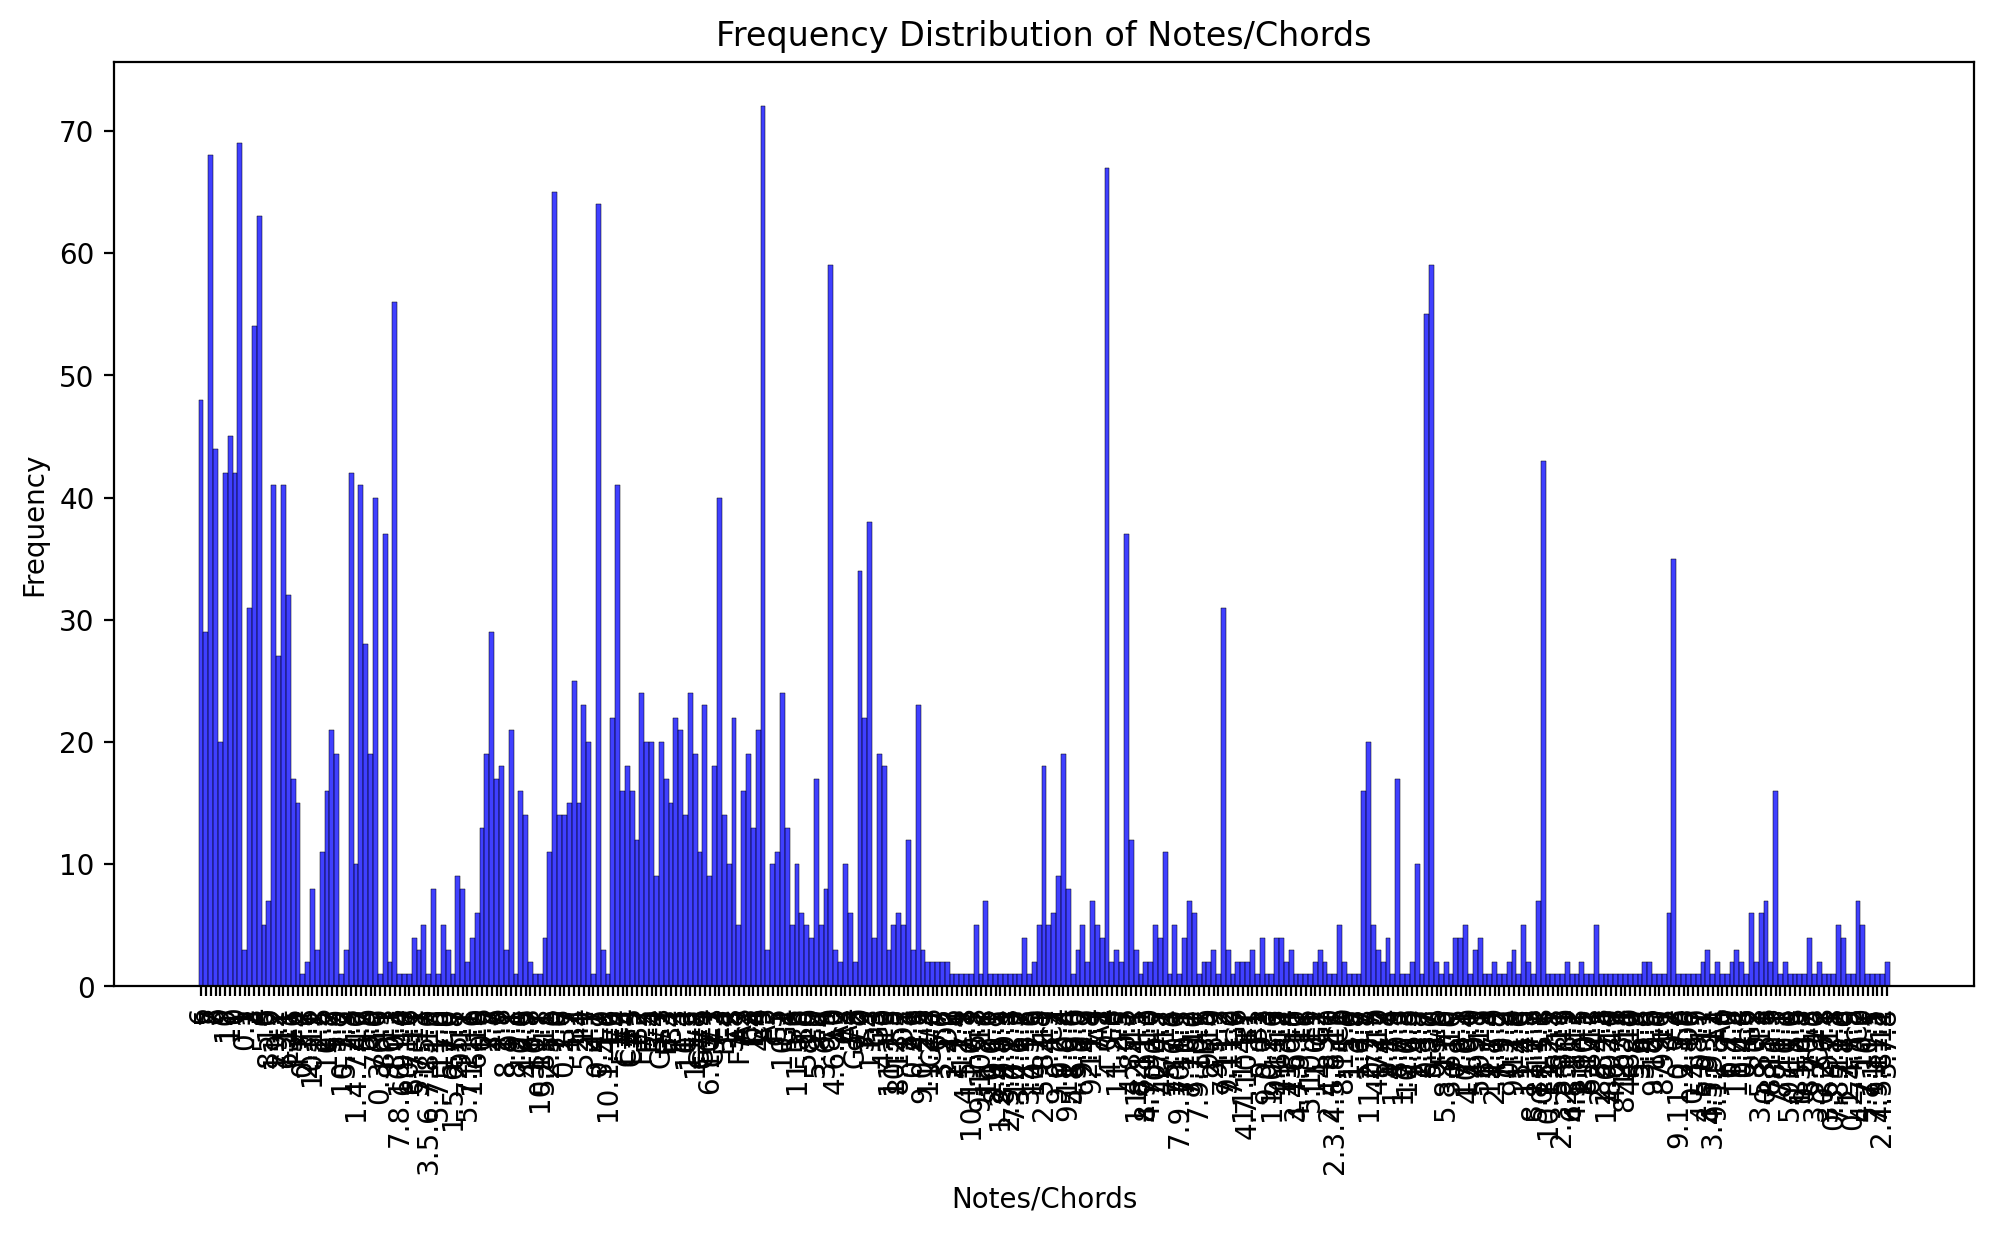

Generated Notes and Chords:
['2.5.8.11', '2.5.8.9', '3.6.9', '1.4.7.9', '1.5.6.7.8', '1.5.6.7.8', '7', '2.3.7', '1.2.4.8.9', '2.5.8.11', '0', '11.1.4', '0.2.5.8', '1.5.6.7.8', '1.5.6.7.8', '10.0.4', '10.0.4', '10.0.4', '0.3.5.8', '7.0', '1', '3.6.7', '10.1.4.6', '6', '1.5.7', '1.4.7', '11.0.4', '2.5.8.11', '1.4.7', '1', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0.2.6.8', '0.2.6.8', '0.2.6.8', '0.2.6.8', '0.2.6.8', '0.2.6.8', '0.2.6.8', '0.2.6.8', '0.2.6.8', '1', '1', '1', '1', '1', '1', '1', '1', '1', '3.4.6.7', '11.1.4.7', '1.5.9', '0.3.6', '1.5.9', '0.3.7', '1.4.7', '0.2', '0', '0', '0', '0', '0.2.5', '0.2.5', '0.2.5', '0.2.5', '0.2.6.8', '0.2.6.8', '0.1', '0.2.5.8', '11.1.6', '11.1', '3.5', '0.2.5.8', '0.4.6', '3.7.8', '3.5', '2.3.4.8', '0.4.6', '0.4.6', '11.4.5', '0.5', '0.2.6.8', '0.2.6.8', '0.2.5.8', '11', '1.2.4.8.9', '10.0.4', '0.5', '0.1.5', '0.1.2', '0.1.5', '10.0.4', '10.0.4', '10.0.4', '11.4.5', '11.4.5', '10.0.4', '0.2.5.8', '11.

Event logged: transcribeStart, {'event_category': 'ismir2021', 'value': 126}
Event logged: transcribeComplete, {'event_category': 'ismir2021', 'value': 126, 'numNotes': 1260, 'numDrumNotes': 0, 'numPrograms': 1}


Event logged: downloadTranscription, {'event_category': 'ismir2021', 'value': 126, 'numNotes': 1260, 'numDrumNotes': 0, 'numPrograms': 1}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Converting MIDI to WAV...
WAV file saved to: /content/drive/MyDrive/SML_Music_final/transcribed.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
from tqdm import tqdm
import os
import warnings
from midi2audio import FluidSynth
from google.colab import files
import librosa
from music21 import *
import note_seq
from google.colab import files

# Define constants
SAMPLE_RATE = 16000
SF2_PATH = '/content/drive/MyDrive/SML_Music_final/FluidR3_GM.sf2'
MODEL = 'ismir2021'

# Suppress warnings
warnings.filterwarnings("ignore")



# Main script
if __name__ == "__main__":
    # User input: Path to a single MIDI file
    file_path = "/content/MIDI-Unprocessed_SMF_17_R1_2004_04_ORIG_MID--AUDIO_17_R1_2004_11_Track11_wav.midi"

    # Step 1: Process the MIDI file
    midi_object = process_midi_file(file_path)

    if midi_object:
        # Step 2: Extract notes and chords
        corpus = extract_notes(midi_object)

        # Step 3: Display Corpus information
        print(f"Corpus created with {len(corpus)} elements.")
        print("Sample notes/chords from the corpus:", corpus[:10])

        # Step 4: Visualize note/chord frequency distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(corpus, kde=False, bins=50, color="blue")
        plt.title("Frequency Distribution of Notes/Chords")
        plt.xlabel("Notes/Chords")
        plt.ylabel("Frequency")
        plt.xticks(rotation=90)
        plt.show()

    # Specify paths
    model = tf.keras.models.load_model('/content/drive/MyDrive/SML_Music_final/model_100.keras')

    # Load pre-trained model
    unique_notes = sorted(list(set(corpus)))
    n_vocab = len(unique_notes)
    sequence_length = 100

    # Prepare sequences
    network_input, normalized_input, note_to_int, int_to_note = prepare_sequences(corpus, n_vocab, sequence_length)

    # Generate predictions
    predicted_notes = generate_sequence(model, network_input, unique_notes, int_to_note, prediction_length=500)  # Increased prediction_length

    # Output predictions
    print("Generated Notes and Chords:")
    print(predicted_notes)

    #  prediction output make a midi file
    create_midi(predicted_notes, output_path='test_output.mid')
    print("MIDI file created successfully.")

    # Convert MIDI to WAV
    print("Converting MIDI to WAV...")
    midi_file_path = '/content/test_output.mid'  # Replace with your MIDI file path
    output_wav_path = '/content/drive/MyDrive/SML_Music_final/generated_music.wav'  # Replace with your desired WAV file path
    convert_midi_to_wav(midi_file_path, output_wav_path)
    print(f"WAV file saved to: {output_wav_path}")

    # TRANSFORMERS
    print("TRANSFORMERS")
    load_gtag()
    file_path = '/content/drive/MyDrive/SML_Music_final/generated_music.wav'  # Update as necessary

    log_event('uploadAudioStart', {})
    audio = upload_audio(file_path, sample_rate=SAMPLE_RATE)
    log_event('uploadAudioComplete', {'value': round(len(audio) / SAMPLE_RATE)})

    note_seq.notebook_utils.colab_play(audio, sample_rate=SAMPLE_RATE)

    est_ns = transcribe_audio(audio, sample_rate=SAMPLE_RATE)
    note_seq.play_sequence(est_ns, synth=note_seq.fluidsynth, sample_rate=SAMPLE_RATE, sf2_path=SF2_PATH)
    note_seq.plot_sequence(est_ns)

    download_midi(est_ns, '/content/drive/MyDrive/SML_Music_final/transcribed.mid')

    # Convert MIDI to WAV
    print("Converting MIDI to WAV...")
    midi_file_path = '/content/drive/MyDrive/SML_Music_final/transcribed.mid'  # Replace with your MIDI file path
    output_wav_path = '/content/drive/MyDrive/SML_Music_final/transcribed.wav'  # Replace with your desired WAV file path
    convert_midi_to_wav(midi_file_path, output_wav_path)
    print(f"WAV file saved to: {output_wav_path}")
    files.download(output_wav_path)